In [1]:
# Class label csv path
labels_csv_path = 'datasets/home_labels.csv'
# output result csv path
output_vclip_path = 'outputs/vclip_results.csv'
output_clap_path = 'outputs/clap_results.csv'

### Load Data from CSV

In [2]:
import csv
import numpy as np

label2id = {}
id2label = {}
with open(labels_csv_path, mode='r') as file:
    csv_reader = csv.reader(file)

    for i, row in enumerate(csv_reader):
        class_name = row[0]
        label2id[class_name] = i
        id2label[i] = class_name

class_labels = list(label2id.keys())

print(f"{len(class_labels)} Unique classes: {class_labels}.")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
70 Unique classes: ['No people is in the room', 'Studying', 'Typing', 'Using computer', 'Making phone calls', 'Play with phone/tablet', 'Playing with pets', 'Sitting down', 'Reading', 'Writing', 'Setting table', 'Eating food', 'Dining', 'Cooking', 'Sleeping', 'Laying down', 'Picking up objects', 'Brushing teeth', 'Showering', 'Playing music', 'TV', 'Cleaning', 'Doing laundry', 'Mopping floor', 'Vacumning', 'Organizing space', 'Sewing', 'Knitting', 'Decorating', 'Party', 'Chatting', 'Talking', 'S

In [11]:
import csv

def read_results(csv_path):
    results = []
    labels = []
    with open(csv_path, mode='r') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)

        for row in csv_reader:
            file_name, label, top1_pred, top1_conf, top2_pred, top2_conf, top3_pred, top3_conf, top4_pred, top4_conf, top5_pred, top5_conf = row
            labels.append(int(label))
            results.append([float(top1_pred), float(top1_conf), float(top2_pred), float(top2_conf), 
                            float(top3_pred), float(top3_conf), float(top4_pred), float(top4_conf), 
                            float(top5_pred), float(top5_conf)])

    # results = np.asarray(results).astype(float)
    # labels  = np.asarray(labels).astype(int)
    return results, labels

In [12]:
vclip_results, vclip_labels = read_results(output_vclip_path)
clap_results, clap_labels = read_results(output_clap_path)

In [33]:
print(len(vclip_results), len(vclip_results[0]))
print(len(clap_results), clap_labels[0])
print(vclip_results[0])
print(vclip_labels[0])


424 10
424 64
[64.0, 98.6816, 66.0, 0.1019, 33.0, 0.098, 0.0, 0.098, 67.0, 0.0493]
64


# Train

In [59]:
X = []
y = []
for i in range(len(vclip_results)):
    if vclip_results[i] != [-1, 0] * 5 and clap_results[i] != [-1, 0] * 5:
        # 212 count
        X.append(vclip_results[i] + clap_results[i]) 
        y.append(vclip_labels[i])
        X.append(vclip_results[i] + [-1, 0] * 5) 
        y.append(vclip_labels[i])
        X.append([-1, 0] * 5 + clap_results[i]) 
        y.append(vclip_labels[i])
    else:
        X.append(vclip_results[i] + clap_results[i]) 
        y.append(vclip_labels[i])

X = np.asarray(X)
y = np.asarray(y)
print(X.shape) # target (848, 20)
print(y.shape) # target (848,)

(848, 20)
(848,)


In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.inspection import permutation_importance


# kf = KFold(n_splits=50)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

classifiers = [
               SVC(kernel='poly'),
               KNeighborsClassifier(),
               KNeighborsClassifier(n_neighbors=12),
               RandomForestClassifier(),
               RandomForestClassifier(criterion='entropy'),
               RandomForestClassifier(criterion='log_loss'),
               RandomForestClassifier(n_estimators=50, criterion='entropy'),
               RandomForestClassifier(n_estimators=30, criterion='entropy', max_depth=5)
            ]

print("Accuracy for")
all_accuracies = []
for clf_model in classifiers:
    # accuracy = []
    # for train_index, test_index in kf.split(X):
    #     X_train, X_test = X[train_index], X[test_index]
    #     y_train, y_test = Y[train_index], Y[test_index]
    #     clf_model.fit(X_train, y_train)
    #     accuracy.append(clf_model.score(X_test, y_test))

    # print("%s: %.2f%%" % (clf_model, np.mean(accuracy) * 100))
    # all_accuracies.append(np.mean(accuracy))

    clf_model.fit(X_train, y_train)
    accuracy = clf_model.score(X_test, y_test)
    print("%s: %.2f%%" % (clf_model, accuracy * 100))
    all_accuracies.append(accuracy)

    

print("Average accuracy across", len(classifiers), "ML models is %.2f%%" % (np.mean(all_accuracies) * 100))



(636, 20) (636,) (212, 20) (212,)
Accuracy for
SVC(kernel='poly'): 82.08%
KNeighborsClassifier(): 84.91%
KNeighborsClassifier(n_neighbors=12): 82.55%
RandomForestClassifier(): 90.57%
RandomForestClassifier(criterion='entropy'): 91.51%
RandomForestClassifier(criterion='log_loss'): 91.51%
RandomForestClassifier(criterion='entropy', n_estimators=50): 91.04%
RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=30): 88.68%
Average accuracy across 8 ML models is 87.85%


In [61]:
selected = 4
selected_model = classifiers[selected]

y_pred = selected_model.predict(X_test)


In [62]:
import joblib

# Save the model to a file
joblib.dump(selected_model, 'trained_RF_ensemble.joblib')

['trained_RF_ensemble.joblib']

In [63]:
print(y_pred)


[69 69 58 69 69 69 64 64 69 56 69 69 69 64 69 64 69 64 69 69 69 64 69 69
 64 60 64 69 56 69 58 64 69 69 69 69 69 60 56 56 69 69 56 69 69 69 64 69
 69 69 69 69 58 69 69 69 58 69 69 69 69 64 56 56 69 69 60 56 69 64 69 56
 69 56 69 69 69 69 69 69 64 60 69 69 64 69 69 69 69 64 69 69 69 69 69 56
 64 56 60 69 69 69 69 69 69 69 56 64 60 64 60 69 69 69 69 64 69 69 60 69
 69 69 62 69 69 69 69 56 69 69 69 69 69 69 69 69 69 69 69 69 64 69 69 60
 69 69 69 56 64 69 69 69 69 69 69 69 60 69 64 56 69 64 69 56 62 69 69 69
 69 60 69 69 62 69 64 69 69 69 69 69 64 69 64 64 64 69 56 69 69 69 69 69
 69 69 69 69 64 60 69 60 69 69 69 69 64 58 69 64 64 64 69 58]


# Per-class Accuracy

In [64]:
from collections import defaultdict

correct = defaultdict(int)
total = defaultdict(int)
for i, label in enumerate(y_test):
    total[label] += 1
    if label == y_pred[i]:
        correct[label] += 1
        
for label in total:
    print(f"{id2label[label]}: {correct[label]} / {total[label]}")

Normal: 126 / 126
Smoke or Fire or Open flame: 6 / 8
Crying: 32 / 34
Glass breaking: 16 / 19
Gunshot: 11 / 14
Falling down: 3 / 11


In [65]:
for i, label in enumerate(y_test):
    if id2label[label] == "Normal":
        pred = y_pred[i]
        print(id2label[pred])

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


# Feature Importance

Feature importance for SVC(kernel='poly') is [ 1.37185535e-01  8.67924528e-02  1.75707547e-02 -3.93081761e-05
  2.75157233e-03  1.96540881e-04  4.83490566e-03  1.57232704e-04
  1.43474843e-02  0.00000000e+00  9.22955975e-02  0.00000000e+00
  4.59512579e-02  0.00000000e+00  5.46776730e-02  0.00000000e+00
  2.29166667e-02  0.00000000e+00  3.20361635e-02  0.00000000e+00]
Feature importance for KNeighborsClassifier() is [ 1.18985849e-01  1.12775157e-01  2.00864780e-02  3.93081761e-05
  1.72169811e-02  1.21855346e-03  9.66981132e-03 -9.43396226e-04
  1.65880503e-02 -9.43396226e-04  7.64544025e-02  0.00000000e+00
  6.81996855e-02  0.00000000e+00  6.55660377e-02  0.00000000e+00
  4.08018868e-02  0.00000000e+00  3.93867925e-02  0.00000000e+00]
Feature importance for KNeighborsClassifier(n_neighbors=12) is [ 1.15762579e-01  9.90566038e-02  2.01257862e-02 -2.35849057e-04
  9.55188679e-03  3.93081761e-05  8.09748428e-03 -7.46855346e-04
  1.66666667e-02  0.00000000e+00  8.90723270e-02  0.00000000e

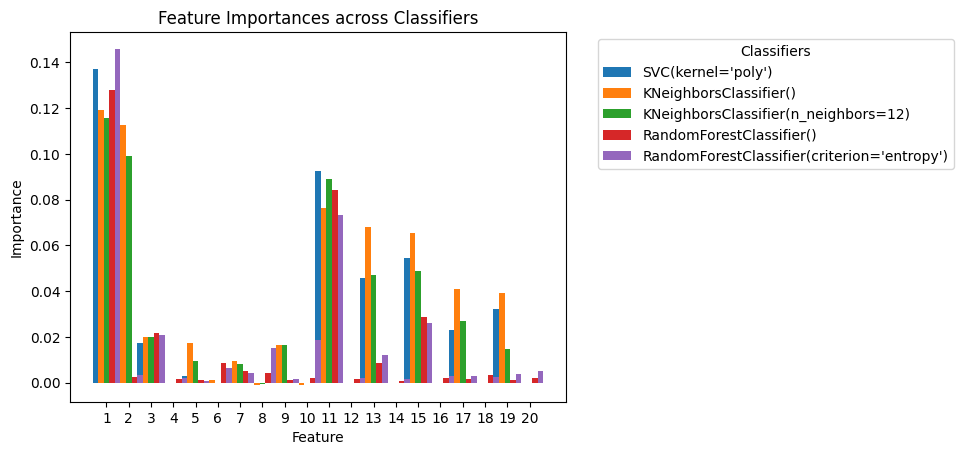

In [66]:
import matplotlib.pyplot as plt 

# feature permutation importance
feature_names = list(range(1, 21))

all_importances = []
for clf_model in classifiers[:selected+1]:
    importance = permutation_importance(clf_model, X_train, y_train, n_repeats=40, random_state=0)
    all_importances.append(importance.importances_mean)
    print("Feature importance for", clf_model, "is", importance.importances_mean)

all_importances = np.array(all_importances)

# Plot 
num_classifiers, num_features = all_importances.shape
bar_width = 0.25  # Width of the bars
x_indices = np.arange(num_features)  # X-axis positions for the bars

# Create a bar for each classifier
for i in range(num_classifiers):
    bars = plt.bar(x_indices + i * bar_width, all_importances[i], width=bar_width, label=str(classifiers[i]))
    # Add rankings
    rankings_id = np.argsort(all_importances[i])[::-1]
    rankings = np.zeros(num_features)
    for i, rank in enumerate(rankings_id):
        rankings[rank] = i

    # for bar, ranking in zip(bars, rankings):
    #     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'#{int(ranking + 1)}', ha='center', va='bottom')

# Labels and Legend
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances across Classifiers')
plt.xticks(x_indices + bar_width * (num_classifiers - 1) / 2, feature_names)
plt.legend(title='Classifiers', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()